# DEA Coastlines summary plots

In [1]:
cd ../'Tools'

/home/jovyan/dev/dea-notebooks/Tools


In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from dea_tools.coastal import get_coastlines

from scipy.stats import ttest_ind
from scipy.stats import ttest_rel

## Load data

In [3]:
# Set study area from vector file

## Use regions_gdf for mainland polygons
regions_gdf = (
    gpd.read_file(
        # "https://data.dea.ga.gov.au/derivative/dea_coastlines/supplementary/australia_mainland_regions.geojson"
        # '/home/jovyan/dev/dea-notebooks/Testing/Buffered_GBR_mngt_areas.shp' ## Management area polygons
        # '/home/jovyan/dev/dea-notebooks/Testing/Manual_all_GBR_Coastlines.shp' ## Greater GBR extent
        # '/home/jovyan/dev/dea-notebooks/Testing/Aus_bbox.shp' ## 
        # '/home/jovyan/dev/dea-notebooks/Testing/mainland_buffered_edited_mngt_regions_incl_allGBR.shp' ## all mainland only extents
        '/home/jovyan/dev/dea-notebooks/Testing/All_GBR_merged.shp' ## all mainland only extents
    )
    # .set_index("Descriptio")
    .set_index("layer")
    # .set_index('id')
)
# regions_gdf

In [4]:
# ## Use regions_gdf_offshore for island and reef polygons
# regions_gdf_offshore = (
#     gpd.read_file(
#         # "https://data.dea.ga.gov.au/derivative/dea_coastlines/supplementary/australia_mainland_regions.geojson"
#         # '/home/jovyan/dev/dea-notebooks/Testing/Buffered_GBR_mngt_areas.shp' ## Management area polygons
#         # '/home/jovyan/dev/dea-notebooks/Testing/Manual_all_GBR_Coastlines.shp' ## Greater GBR extent
#         '/home/jovyan/dev/dea-notebooks/Testing/islands_management_regions_incl_allGBR.shp' ## all reef and island extents
#     )
    
    
#     # .set_index("Descriptio")
#     # .set_index("layer")
#     .set_index('AREA_DESCR')
# )
# # regions_gdf_offshore


In [5]:
print(regions_gdf.index)
# print(regions_gdf_offshore.index)

Index(['Australia', 'Mainland_CairnsCook', 'Mainland_FarNorth', 'Mainland_GBR',
       'Mainland_MackCap', 'Mainland_TownsWhit', 'All_GBR',
       'Offshore_CairnsCook', 'Offshore_FarNorth', 'Offshore_GBR',
       'Offshore_MackCap', 'Offshore_TownsWhit', 'All_FarNorth',
       'All_CairnsCook', 'All_TownsWhit', 'All_MackCap'],
      dtype='object', name='layer')


In [11]:
study_area = regions_gdf.loc[["All_GBR"]]
# study_area_offshore = regions_gdf_offshore.loc[['All_GBR_offshore']]
# study_area = regions_gdf.loc[["1"]]
# study_area = regions_gdf

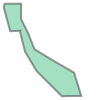

In [12]:
study_area.geometry[0]

In [8]:
# study_area_offshore.geometry[0]

In [9]:
# Load data from WFS for study area bounding box
bbox = study_area.geometry.bounds.values[0]
# bbox = study_area.geometry.bounds#.values[0]
ratesofchange_gdf = get_coastlines(
    bbox=bbox, layer="rates_of_change"
)

# Clip returned data to polygon extent
ratesofchange_gdf = gpd.clip(ratesofchange_gdf, mask=study_area.to_crs("EPSG:3577"))
ratesofchange_gdf.head()

,id,uid,rate_time,sig_time,se_time,outl_time,dist_1988,dist_1989,dist_1990,dist_1991,...,angle_std,valid_obs,valid_span,sce,nsm,max_year,min_year,certainty,id_primary,geometry
317950,rates_of_change.1199380,r7sheu4wj6,1.07,0.011,0.40,2022,-85.35,-85.38,-88.28,-75.75,...,10,34,34,86.41,85.35,2019,2012,baseline outlier,QLD15,POINT (2000851.727 -2803663.727)
317951,rates_of_change.1199381,r7sheu4x0z,1.29,0.004,0.41,None,-83.83,-80.88,-85.33,-71.65,...,9,35,35,106.96,83.83,2022,2012,good,QLD15,POINT (2000835.916 -2803638.205)
317952,rates_of_change.1199382,r7sheu627g,1.20,0.006,0.41,None,-81.56,-76.79,-80.38,-64.87,...,10,35,35,104.53,81.56,2022,2012,good,QLD15,POINT (2000818.707 -2803613.637)
317953,rates_of_change.1199383,r7sheu61qy,1.10,0.011,0.41,None,-75.76,-69.09,-69.37,-61.37,...,10,35,35,99.56,75.76,2022,2012,good,QLD15,POINT (2000800.724 -2803589.631)
317954,rates_of_change.1199384,r7sheu64d5,0.97,0.020,0.39,None,-71.82,-64.09,-65.70,-57.12,...,9,35,35,95.74,71.82,2022,2012,good,QLD15,POINT (2000783.921 -2803564.747)


In [ ]:
# ## Repeat for offshore polygon

# # Load data from WFS for study area bounding box
# bbox_offshore = study_area_offshore.geometry.bounds.values[0]
# # bbox = study_area.geometry.bounds#.values[0]
# ratesofchange_gdf_offshore = get_coastlines(
#     bbox=bbox_offshore, layer="rates_of_change"
# )

# # Clip returned data to polygon extent
# ratesofchange_gdf_offshore = gpd.clip(ratesofchange_gdf_offshore, mask=study_area_offshore.to_crs("EPSG:3577"))
# ratesofchange_gdf_offshore.head()

In [ ]:
# ## Temp - bring in csv version of Australian ratesofchange_gdf and clip to management boundaries for plotting

from shapely import wkt

allAus = pd.read_csv("/home/jovyan/dev/dea-notebooks/Testing/All_Aust_16-10-2023.csv")

allAus['geometry'] = allAus['geometry'].apply(wkt.loads)
allAus_gdf = gpd.GeoDataFrame(allAus, crs = 'epsg:4326')
# allAus_gdf.head(2)

In [23]:
ratesofchange_gdf = gpd.clip(allAus_gdf, mask=study_area.to_crs("EPSG:3577"))

ratesofchange_gdf.head()

/tmp/ipykernel_537/3357488663.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:3577

  ratesofchange_gdf = gpd.clip(allAus_gdf, mask=study_area.to_crs("EPSG:3577"))


,Unnamed: 0,id,uid,rate_time,sig_time,se_time,outl_time,dist_1988,dist_1989,dist_1990,...,max_year,min_year,certainty,id_primary,geometry,2019-2022_epoch_rate_time,y_coord,x_coord,2019-2022_epoch_rate_time_sig_filtered,rate_time_sig_filtered
392790,979188,rates_of_change.979186,rk4p5rc3tr,-1.01,0.067,0.58,NaN,69.35,55.75,41.33,...,2002,2003,good,QLD12,POINT (1768690.10309 -2399983.51520),-8.085,-2.399984e+06,1.768690e+06,0.0,0.0
392791,979191,rates_of_change.979189,rk4p5rcg0p,-0.77,0.011,0.31,1996 1997 2003 2004,20.62,3.28,-9.11,...,2005,2021,good,QLD12,POINT (1768740.60748 -2399961.35174),-1.617,-2.399961e+06,1.768741e+06,0.0,0.0
392792,979194,rates_of_change.979192,rk4p5rfk9s,-0.86,0.401,1.11,NaN,4.07,-1.62,-63.41,...,1999,2003,good,QLD12,POINT (1768820.82797 -2399945.12510),20.169,-2.399945e+06,1.768821e+06,0.0,0.0
392793,979192,rates_of_change.979190,rk4p5rcs46,-0.32,0.459,0.53,2003,45.59,14.55,-7.83,...,2005,2004,good,QLD12,POINT (1768718.06858 -2399942.12255),1.176,-2.399942e+06,1.768718e+06,0.0,0.0
392794,979197,rates_of_change.979195,rk4p5rfhfg,-0.64,0.113,0.44,1996 1997 2003 2004,5.69,0.41,-53.29,...,2005,2021,good,QLD12,POINT (1768792.48543 -2399936.72071),14.843,-2.399937e+06,1.768792e+06,0.0,0.0


In [25]:
## Temp - bring in csv version of Australian ratesofchange_gdf and clip to management boundaries for plotting
# gpd.read_file("/home/jovyan/dev/dea-notebooks/Testing/All_Aust_16-10-2023.csv")

# Reading only geometries intersecting ``mask``:

# >>> df = geopandas.read_file("nybb.shp", mask=polygon)  # doctest: +SKIP


# gdf_mask = gpd.read_file("/home/jovyan/dev/dea-notebooks/Testing/All_Aust_16-10-2023.csv", crs = 'epsg:4326')
# regions_gdf = (gpd.read_file('/home/jovyan/dev/dea-notebooks/Testing/All_GBR_merged.shp').set_index("layer"))

# allAus_gdf = allAus_gdf.to_crs(crs = 'epsg:4326')
# regions_gdf = regions_gdf.to_crs(crs = 'epsg:4326')

# gpd.read_file(allAus_gdf, mask=regions_gdf.loc[['Mainland_CairnsCook']])
# mask = regions_gdf.loc[['Australia']].geometry#.boundary
# allAus_gdf.to_crs("EPSG:3577").clip(mask)

In [ ]:
# mask_gdf = gpd.GeoDataFrame([1], geometry=mask, crs = allAus_gdf.crs)
# mask_gdf

In [ ]:
## Epoch based change
### NOTE: there are three places in this code cell where epoch dates need to be adjusted

## Create a linear regression object
linear_regressor = LinearRegression()

## Set the dates (add 1 to your end date)
x=np.arange(2019, 2023, 1).reshape(-1,1) 

## Define the function to take each row of the gdf and calculate the linear regression 
## coefficient for the time period of interest
def epoch_rate_time(x,y,linear_regressor):
    
    try:
        # If Nans in 'y', remove them and their equivalent indexed values from 'x'
        if pd.isnull(y).any() == True:
            x= np.delete(x, np.argwhere(y.values!=y.values).flatten(order='C')).reshape(-1,1)
            y= y.dropna().values
        else:
            y = y.values
        # Calculate the linear regression
        linear_regressor.fit(x,y)
        # Return only the coefficient into the gdf
        return linear_regressor.coef_[0]
    except:
        print(f'An exception error occurred at {y.id}')

### rename gdf column to match input dates and adjust slices to match exact input and output years
ratesofchange_gdf['2019-2022_epoch_rate_time'] = ratesofchange_gdf.apply(lambda y: epoch_rate_time(x,       
                                                                                                     y.loc['dist_2019':'dist_2022'],  
                                                                                                     linear_regressor), axis=1)
ratesofchange_gdf.head()

In [ ]:
# ## Repeat for offshore polygons
# ## Epoch based change
# ### NOTE: there are three places in this code cell where epoch dates need to be adjusted

# # ## Create a linear regression object
# # linear_regressor = LinearRegression()

# # ## Set the dates (add 1 to your end date)
# # x=np.arange(2019, 2023, 1).reshape(-1,1) 

# # ## Define the function to take each row of the gdf and calculate the linear regression 
# # ## coefficient for the time period of interest
# # def epoch_rate_time(x,y,linear_regressor):
    
# #     try:
# #         # If Nans in 'y', remove them and their equivalent indexed values from 'x'
# #         if pd.isnull(y).any() == True:
# #             x= np.delete(x, np.argwhere(y.values!=y.values).flatten(order='C')).reshape(-1,1)
# #             y= y.dropna().values
# #         else:
# #             y = y.values
# #         # Calculate the linear regression
# #         linear_regressor.fit(x,y)
# #         # Return only the coefficient into the gdf
# #         return linear_regressor.coef_[0]
# #     except:
# #         print(f'An exception error occurred at {y.id}')

# ### rename gdf column to match input dates and adjust slices to match exact input and output years
# ratesofchange_gdf_offshore['2019-2022_epoch_rate_time'] = ratesofchange_gdf_offshore.apply(lambda y: epoch_rate_time(x,       
#                                                                                                      y.loc['dist_2019':'dist_2022'],  
#                                                                                                      linear_regressor), axis=1)
# ratesofchange_gdf_offshore.head()

In [ ]:
# ## Temp: compare my method to Robbi's

# # Optional: Keep only rates of change points with "good" certainty 
# # (i.e. no poor quality flags)
# ratesofchange_gdf = ratesofchange_gdf.query("certainty == 'good'")

# ratesofchange_gdf['1988-2022_epoch_rate_time'] = ratesofchange_gdf['1988-2022_epoch_rate_time'].round(2)

# ratesofchange_gdf[['rate_time','1988-2022_epoch_rate_time', '2014-2018_epoch_rate_time','2019-2022_epoch_rate_time']]

In [ ]:
# ## Temp: compare my method to Robbi's
# ## Noise possibly caused by my method not removing outliers
# plt.scatter(ratesofchange_gdf.rate_time, ratesofchange_gdf['1988-2022_epoch_rate_time'])

## Data prep

In [ ]:
# Optional: Keep only rates of change points with "good" certainty 
# (i.e. no poor quality flags)
ratesofchange_gdf = ratesofchange_gdf.query("certainty == 'good'")

# Optional: Apply correction factor from Bishop-Taylor et al. 2021
ratesofchange_gdf.rate_time += 0.08

# ratesofchange_gdf['2014-2022_epoch_rate_time']+= 0.08
# ratesofchange_gdf['2014-2017_epoch_rate_time']+= 0.08
# ratesofchange_gdf['1988-2022_epoch_rate_time']+= 0.08
# ratesofchange_gdf['2014-2018_epoch_rate_time']+= 0.08
ratesofchange_gdf['2019-2022_epoch_rate_time']+= 0.08

# Add x and y coords to data
ratesofchange_gdf["y_coord"] = ratesofchange_gdf.geometry.y
ratesofchange_gdf["x_coord"] = ratesofchange_gdf.geometry.x

In [ ]:
# ## Repeat for offshore polygons
# # Optional: Keep only rates of change points with "good" certainty 
# # (i.e. no poor quality flags)
# ratesofchange_gdf_offshore = ratesofchange_gdf_offshore.query("certainty == 'good'")

# # Optional: Apply correction factor from Bishop-Taylor et al. 2021
# ratesofchange_gdf_offshore.rate_time += 0.08

# # ratesofchange_gdf['2014-2022_epoch_rate_time']+= 0.08
# # ratesofchange_gdf['2014-2017_epoch_rate_time']+= 0.08
# # ratesofchange_gdf['1988-2022_epoch_rate_time']+= 0.08
# # ratesofchange_gdf['2014-2018_epoch_rate_time']+= 0.08
# ratesofchange_gdf_offshore['2019-2022_epoch_rate_time']+= 0.08

# # Add x and y coords to data
# ratesofchange_gdf_offshore["y_coord"] = ratesofchange_gdf_offshore.geometry.y
# ratesofchange_gdf_offshore["x_coord"] = ratesofchange_gdf_offshore.geometry.x

In [ ]:
## Temp
# ratesofchange_gdf#['2014-2017_epoch_rate_time'] 

In [ ]:
# Replace with 0 all rates with 'sig_time' > 0.01

# Make a copy of the column of interest
ratesofchange_gdf['2019-2022_epoch_rate_time_sig_filtered'] = ratesofchange_gdf['2019-2022_epoch_rate_time']

## Replace with 0 all values where sig_time > 0.01
ratesofchange_gdf.loc[ratesofchange_gdf['sig_time'] > 0.01, '2019-2022_epoch_rate_time_sig_filtered'] = 0
# ratesofchange_gdf[['sig_time', '2019-2022_epoch_rate_time','2019-2022_epoch_rate_time_sig_filtered']] 

## Repeat for all-time change rates
ratesofchange_gdf['rate_time_sig_filtered'] = ratesofchange_gdf['rate_time']

## Replace with 0 all values where sig_time > 0.01
ratesofchange_gdf.loc[ratesofchange_gdf['sig_time'] > 0.01, 'rate_time_sig_filtered'] = 0
ratesofchange_gdf[['sig_time', 'rate_time','rate_time_sig_filtered']] 

In [ ]:
# ## Repeat for offshore polygons
# # Replace with 0 all rates with 'sig_time' > 0.01

# # Make a copy of the column of interest
# ratesofchange_gdf_offshore['2019-2022_epoch_rate_time_sig_filtered'] = ratesofchange_gdf_offshore['2019-2022_epoch_rate_time']

# ## Replace with 0 all values where sig_time > 0.01
# ratesofchange_gdf_offshore.loc[ratesofchange_gdf_offshore['sig_time'] > 0.01, '2019-2022_epoch_rate_time_sig_filtered'] = 0
# # ratesofchange_gdf[['sig_time', '2019-2022_epoch_rate_time','2019-2022_epoch_rate_time_sig_filtered']] 

# ## Repeat for all-time change rates
# ratesofchange_gdf_offshore['rate_time_sig_filtered'] = ratesofchange_gdf_offshore['rate_time']

# ## Replace with 0 all values where sig_time > 0.01
# ratesofchange_gdf_offshore.loc[ratesofchange_gdf_offshore['sig_time'] > 0.01, 'rate_time_sig_filtered'] = 0
# ratesofchange_gdf_offshore[['sig_time', 'rate_time','rate_time_sig_filtered']] 

In [32]:
ratesofchange_gdf

,Unnamed: 0,id,uid,rate_time,sig_time,se_time,outl_time,dist_1988,dist_1989,dist_1990,...,max_year,min_year,certainty,id_primary,geometry,2019-2022_epoch_rate_time,y_coord,x_coord,2019-2022_epoch_rate_time_sig_filtered,rate_time_sig_filtered
392790,979188,rates_of_change.979186,rk4p5rc3tr,-1.01,0.067,0.58,NaN,69.35,55.75,41.33,...,2002,2003,good,QLD12,POINT (1768690.10309 -2399983.51520),-8.085,-2.399984e+06,1.768690e+06,0.000,0.00
392791,979191,rates_of_change.979189,rk4p5rcg0p,-0.77,0.011,0.31,1996 1997 2003 2004,20.62,3.28,-9.11,...,2005,2021,good,QLD12,POINT (1768740.60748 -2399961.35174),-1.617,-2.399961e+06,1.768741e+06,0.000,0.00
392792,979194,rates_of_change.979192,rk4p5rfk9s,-0.86,0.401,1.11,NaN,4.07,-1.62,-63.41,...,1999,2003,good,QLD12,POINT (1768820.82797 -2399945.12510),20.169,-2.399945e+06,1.768821e+06,0.000,0.00
392793,979192,rates_of_change.979190,rk4p5rcs46,-0.32,0.459,0.53,2003,45.59,14.55,-7.83,...,2005,2004,good,QLD12,POINT (1768718.06858 -2399942.12255),1.176,-2.399942e+06,1.768718e+06,0.000,0.00
392794,979197,rates_of_change.979195,rk4p5rfhfg,-0.64,0.113,0.44,1996 1997 2003 2004,5.69,0.41,-53.29,...,2005,2021,good,QLD12,POINT (1768792.48543 -2399936.72071),14.843,-2.399937e+06,1.768792e+06,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474765,741429,rates_of_change.741006,rhzy8ftnzz,-0.10,0.002,0.06,NaN,9.36,9.59,10.97,...,2002,2016,good,QLD10,POINT (1483788.33687 -1906341.41068),-0.844,-1.906341e+06,1.483788e+06,-0.844,-0.10
474766,741430,rates_of_change.741007,rhzy8fv05y,-0.04,0.010,0.04,NaN,7.20,7.32,7.58,...,2002,2022,good,QLD10,POINT (1483772.51940 -1906316.08248),-0.728,-1.906316e+06,1.483773e+06,-0.728,-0.04
474767,741431,rates_of_change.741008,rhzy8fv180,0.02,0.105,0.04,NaN,4.94,5.18,5.09,...,2003,1994,good,QLD10,POINT (1483758.55881 -1906289.58856),-0.699,-1.906290e+06,1.483759e+06,0.000,0.00
474768,741432,rates_of_change.741009,rhzy8fufu0,-0.01,0.008,0.03,NaN,4.00,4.58,5.38,...,2003,2017,good,QLD10,POINT (1483742.53881 -1906264.23406),-0.520,-1.906264e+06,1.483743e+06,-0.520,-0.01


In [26]:
# Resample to make sure we have evenly spaced rows (important for sensible rolling mean)
bin_size = 30
min_coord = ratesofchange_gdf["y_coord"].min()
max_coord = ratesofchange_gdf["y_coord"].max()
bin_edges = np.arange(min_coord, max_coord, bin_size)
groups = pd.cut(
    ratesofchange_gdf["y_coord"],
    bins=bin_edges,
    labels=bin_edges[:-1] + (bin_size / 2),
    right=False,
)
# ratesofchange_standardised_gdf = ratesofchange_gdf.groupby(groups).mean() ## Original code
ratesofchange_standardised_gdf = ratesofchange_gdf.groupby(groups).mean() ## TEMPORARY CHANGE FOR TESTING 21/09/23 CP

# Set index to numeric so we can plot it nicely
ratesofchange_standardised_gdf.index = pd.to_numeric(
    ratesofchange_standardised_gdf.index
)

/tmp/ipykernel_537/2487466029.py:13: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  ratesofchange_standardised_gdf = ratesofchange_gdf.groupby(groups).mean() ## TEMPORARY CHANGE FOR TESTING 21/09/23 CP
/tmp/ipykernel_537/2487466029.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratesofchange_standardised_gdf = ratesofchange_gdf.groupby(groups).mean() ## TEMPORARY CHANGE FOR TESTING 21/09/23 CP


## Rolling mean

In [27]:
# Apply rolling median
window_size = 15000  # km
window_n = int(window_size / 30)
ratesofchange_rolling_gdf = ratesofchange_standardised_gdf.rolling(
    window=window_n, center=True, min_periods=1
).mean()

# Apply an additional level of aesthetic smoothing (can be removed)
ratesofchange_rolling_gdf = ratesofchange_rolling_gdf.rolling(
    window=window_n, center=True, min_periods=1
).mean()

## Plotting

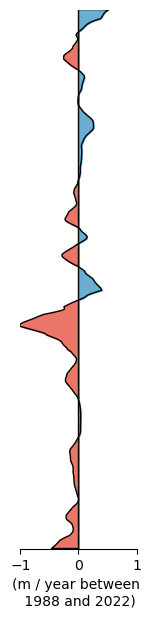

In [30]:
## All time plotting

# Set first and last entry to zero so we get clean graph outlines
ratesofchange_rolling_gdf["rate_time_sig_filtered"].iloc[0] = 0
ratesofchange_rolling_gdf["rate_time_sig_filtered"].iloc[-1] = 0

# Split out positive and negative rates so we can plot them individually
ratesofchange_positive_gdf = ratesofchange_rolling_gdf["rate_time_sig_filtered"].clip(0, np.inf)
ratesofchange_negative_gdf = ratesofchange_rolling_gdf["rate_time_sig_filtered"].clip(-np.inf, 0)

# Plot negative rates in red, positive in blue
fig, ax = plt.subplots(figsize=(1.5, 7))#1.75))#5))#7))
ax.fill_betweenx(
    ratesofchange_positive_gdf.index, 0, ratesofchange_positive_gdf, color="#6caed1"
)
ax.fill_betweenx(
    ratesofchange_negative_gdf.index, ratesofchange_negative_gdf, 0, color="#eb7668"
)
ax.plot(
    ratesofchange_rolling_gdf["rate_time_sig_filtered"],
    ratesofchange_rolling_gdf.index,
    color="black",
    linewidth=1,
)

# Add vertical axis line
ax.axvline(0, color="black", linewidth=1)

# Styling
ax.set_xlim(-1, 1)
ax.set_ylim(min_coord, max_coord)
ax.set_xticks(ticks=[-1, 0, 1])
ax.set_xlabel("(m / year between \n 1988 and 2022)")
ax.spines[["top", "left", "right"]].set_visible(False)
ax.tick_params(top=False, left=False, labelleft=False, labeltop=False)

# Export
fig.savefig("/home/jovyan/dev/dea-notebooks/Testing/all_time_sig_time_filtered_all_GBR_mngt_area4.svg", bbox_inches="tight", transparent=True)

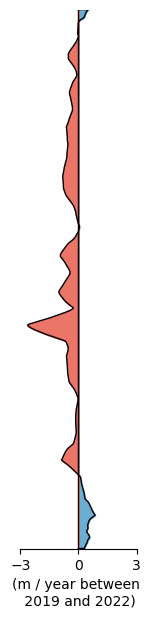

In [31]:
## Epoch plotting (without outlier removal - unlike original rate_time method)

# Set first and last entry to zero so we get clean graph outlines
ratesofchange_rolling_gdf['2019-2022_epoch_rate_time_sig_filtered'].iloc[0] = 0
ratesofchange_rolling_gdf['2019-2022_epoch_rate_time_sig_filtered'].iloc[-1] = 0

# Split out positive and negative rates so we can plot them individually
ratesofchange_positive_gdf = ratesofchange_rolling_gdf['2019-2022_epoch_rate_time_sig_filtered'].clip(0, np.inf)
ratesofchange_negative_gdf = ratesofchange_rolling_gdf['2019-2022_epoch_rate_time_sig_filtered'].clip(-np.inf, 0)

# Plot negative rates in red, positive in blue
fig, ax = plt.subplots(figsize=(1.5, 7))#5))#7))
ax.fill_betweenx(
    ratesofchange_positive_gdf.index, 0, ratesofchange_positive_gdf, color="#6caed1"
)
ax.fill_betweenx(
    ratesofchange_negative_gdf.index, ratesofchange_negative_gdf, 0, color="#eb7668"
)
ax.plot(
    ratesofchange_rolling_gdf['2019-2022_epoch_rate_time_sig_filtered'],
    ratesofchange_rolling_gdf.index,
    color="black",
    linewidth=1,
)

# Add vertical axis line
ax.axvline(0, color="black", linewidth=1)

# Styling
ax.set_xlim(-1, 1)
ax.set_ylim(min_coord, max_coord)
ax.set_xticks(ticks=[-3, 0, 3])
ax.set_xlabel("(m / year between \n 2019 and 2022)")
ax.spines[["top", "left", "right"]].set_visible(False)
ax.tick_params(top=False, left=False, labelleft=False, labeltop=False)

# Export
fig.savefig("/home/jovyan/dev/dea-notebooks/Testing/2019_to_2022_sig_time_filtered_all_GBR_mngt_area4_long.svg", bbox_inches="tight", transparent=True)

In [ ]:
ratesofchange_gdf.to_csv("/home/jovyan/dev/dea-notebooks/Testing/DEACoastlines_ratesofchange_GBR_mngt_area_all.csv")

## Tabular summaries

In [ ]:
region = 'GBR_mainland'

In [ ]:
## Baseline comparison stats for mainland polygons
v1 = ratesofchange_gdf['rate_time_sig_filtered'].values
v2 = ratesofchange_gdf['2019-2022_epoch_rate_time_sig_filtered'].values

rel = ttest_rel(v1,v2)
rel

In [ ]:
ratetimemean = ratesofchange_gdf['rate_time_sig_filtered'].mean().round(2)
ratetimestd = round(ratesofchange_gdf['rate_time_sig_filtered'].std(),2)
epochmean = ratesofchange_gdf['2019-2022_epoch_rate_time_sig_filtered'].mean().round(2)
epochstd = round(ratesofchange_gdf['2019-2022_epoch_rate_time_sig_filtered'].std(),2)

# Append new row to dataframe
StatSummary.loc[len(StatSummary.index)] =          [f'{ratetimemean} ({ratetimestd})', 
                                                   f'{epochmean} ({epochstd})',
                                                   rel.pvalue.round(2),
                                                   round(rel.statistic,2),
                                                   rel.df]
## Update index label
StatSummary.rename(index={StatSummary.loc[len(StatSummary.index)-1].name:region},inplace=True)

In [ ]:
region = 'GBR_offshore'

In [ ]:
## Baseline comparison stats for offshore polygons
v1 = ratesofchange_gdf_offshore['rate_time_sig_filtered'].values
v2 = ratesofchange_gdf_offshore['2019-2022_epoch_rate_time_sig_filtered'].values

rel = ttest_rel(v1,v2)
rel


In [ ]:

ratetimemean = ratesofchange_gdf_offshore['rate_time_sig_filtered'].mean().round(2)
ratetimestd = round(ratesofchange_gdf_offshore['rate_time_sig_filtered'].std(),2)
epochmean = ratesofchange_gdf_offshore['2019-2022_epoch_rate_time_sig_filtered'].mean().round(2)
epochstd = round(ratesofchange_gdf_offshore['2019-2022_epoch_rate_time_sig_filtered'].std(),2)

## Run once as the master dataframe
# data = {
#         '1988-2022':f'{ratetimemean} ({ratetimestd})', 
#         '2019-2022':f'{epochmean} ({epochstd})',
#         'pvalue (1988-2022 vs 2019-2022)':rel.pvalue,
#         'tstat (1988-2022 vs 2019-2022)':round(rel.statistic,2),
#         'df (1988-2022 vs 2019-2022)':rel.df
#         }
# StatSummary = pd.DataFrame(data, index=[region]) 

# Append new row to dataframe
StatSummary.loc[len(StatSummary.index)] =          [f'{ratetimemean} ({ratetimestd})', 
                                                   f'{epochmean} ({epochstd})',
                                                   round(rel.pvalue,2),
                                                   round(rel.statistic,2),
                                                   rel.df
                                                  ]
                                          
## Update index label
StatSummary.rename(index={StatSummary.loc[len(StatSummary.index)-1].name:region},inplace=True)
StatSummary

In [ ]:
StatSummary.to_csv("/home/jovyan/dev/dea-notebooks/Testing/StatSummary.csv")

In [ ]:
region = 'GBR'

In [ ]:
v1 = ratesofchange_gdf['rate_time_sig_filtered'].values
v2 = ratesofchange_gdf_offshore['rate_time_sig_filtered'].values

rel = ttest_ind(v1,v2,equal_var=False)
rel

In [ ]:
v1 = ratesofchange_gdf['2019-2022_epoch_rate_time_sig_filtered'].values
v2 = ratesofchange_gdf_offshore['2019-2022_epoch_rate_time_sig_filtered'].values

rel2 = ttest_ind(v1,v2,equal_var=False)
rel2

In [ ]:
## Capture statistical significance in onshore vs offshore regions

## Run once as master dataframe
# data = {
#         'Onshore vs Offshore (1988-2022) tstat': rel.statistic.round(2),
#         'Onshore vs Offshore (1988-2022) pvalue': rel.pvalue.round(2),
#         'Onshore vs Offshore (2019-2022) tstat': rel2.statistic.round(2),
#         'Onshore vs Offshore (2019-2022) pvalue': rel2.pvalue.round(2)
#         }
# OnOffshoreSummary = pd.DataFrame(data, index=[region])

## Append new row to dataframe
OnOffshoreSummary.loc[len(OnOffshoreSummary.index)] = [rel.statistic.round(2),
                                                       rel.pvalue.round(2),
                                                       rel2.statistic.round(2),
                                                       rel2.pvalue.round(2)]
OnOffshoreSummary.rename(index={OnOffshoreSummary.loc[len(OnOffshoreSummary.index)-1].name:region}, inplace=True)
                                                       


In [ ]:
OnOffshoreSummary

In [ ]:
OnOffshoreSummary.to_csv("/home/jovyan/dev/dea-notebooks/Testing/OnOffshoreSummary.csv")

# After: https://gist.github.com/robbibt/760dcf367be4b98c493e70dd577aca6a

In [ ]:
def change_summary(df, sig=0.01, rate=0.30, bias=0.08):

    # Create booleans indicating whether points were significant
    # or greatert than the minimum accuracy of the method
    sig_bool = df.sig_time <= sig
    # rate_bool = (df.rate_time + bias).abs() >= rate #CP removed as the bias correction has already been applied
    rate_bool = (df.rate_time).abs() >= rate

    # Calculate dynamic % (sig points greater than min rate)
    stat_dict = {}
    stat_dict['dynamic'] = (sig_bool & rate_bool).mean()

    # Calculate stable % (non-sig points or less than min rate)
    stat_dict['stable'] = 1.0 - stat_dict['dynamic']

    # For each rate of change categoru, calculate percent greater
    # (prograding) or percent smaller (eroding coasts)

    for rate_cat in [0.0, 0.5, 1.0, 3.0, 5.0]:
        stat_dict[f'eroding_{rate_cat}'] = (
            # sig_bool & rate_bool & (df.rate_time + bias < -rate_cat)).mean() #CP removed as the bias correction has already been applied
            sig_bool & rate_bool & (df.rate_time < -rate_cat)).mean()
        stat_dict[f'prograd_{rate_cat}'] = (
            # sig_bool & rate_bool & (df.rate_time + bias > rate_cat)).mean() #CP removed as the bias correction has already been applied
            sig_bool & rate_bool & (df.rate_time > rate_cat)).mean()

    return pd.Series(stat_dict)

In [ ]:
# Load point data and Coastal Compartment regions data
# coastlines_data = gpd.read_file('../releases/DEACoastlines_v1.0.0/Shapefile/DEACoastlines_ratesofchange_v1.0.0.shp')[['rate_time', 'sig_time', 'geometry']]
coastlines_data = ratesofchange_gdf[['2019-2022_epoch_rate_time', 'sig_time', 'geometry']]
coastlines_data = coastlines_data.rename(columns={'2019-2022_epoch_rate_time' : 'rate_time'})
# acsc_regions = gpd.read_file('/g/data/r78/DEACoastlines/input_data/Coastal_compartments/Shapefiles_v3/Regions.shp').dissolve('Descriptio')
acsc_regions = regions_gdf.dissolve('layer')


In [ ]:
# Join coastal compartments to points
from geopandas import gpd 
coastlines_joined = gpd.sjoin(coastlines_data, acsc_regions.to_crs('EPSG:3577'), op='within') 

In [ ]:
regions_gdf.index

Create continental summary change table

In [ ]:
# Compute summaries of change for all regions
summary_df = coastlines_joined.groupby(['index_right']).apply(lambda x: change_summary(x)).T
summary_df['Continental'] = change_summary(df=coastlines_joined, sig=0.01)

# # Sort into pretty format
summary_df = summary_df.loc[[
    'dynamic', 'stable', 'eroding_0.0', 'eroding_0.5', 'eroding_1.0',
    'eroding_3.0', 'eroding_5.0', 'prograd_0.0', 'prograd_0.5', 'prograd_1.0',
    'prograd_3.0', 'prograd_5.0'
], [
    'Australia', 'Mainland_CairnsCook', 'Mainland_FarNorth', 'Mainland_GBR',
       'Mainland_MackCap', 'Mainland_TownsWhit', 'All_GBR',
       'Offshore_CairnsCook', 'Offshore_FarNorth', 'Offshore_GBR',
       'Offshore_MackCap', 'Offshore_TownsWhit', 'All_FarNorth',
       'All_CairnsCook', 'All_TownsWhit', 'All_MackCap'
]]

# Rename index
summary_df.index = ['Dynamic', 'Stable', 
                    'Eroding',     
                    '    > 0.5 m / year', '    > 1.0 m / year', 
                    '    > 3.0 m / year', '    > 5.0 m / year', 
                    'Prograding', 
                    '    > 0.5 m / year', '    > 1.0 m / year', 
                    '    > 3.0 m / year', '    > 5.0 m / year']

# Scale and round
(summary_df * 100).round(2)

In [ ]:
summary_df_round = (summary_df * 100).round(2)
Epoch_2019_2022_summary = summary_df_round[['Australia', 
                                      'All_GBR', 'Mainland_GBR', 'Offshore_GBR',
                                      'All_FarNorth','Mainland_FarNorth','Offshore_FarNorth', 
                                      'All_CairnsCook','Mainland_CairnsCook', 'Offshore_CairnsCook',
                                      'All_TownsWhit','Mainland_TownsWhit','Offshore_TownsWhit',
                                      'All_MackCap', 'Mainland_MackCap', 'Offshore_MackCap']]

In [ ]:
regions_gdf.index

In [ ]:
All_time_summary.to_csv("/home/jovyan/dev/dea-notebooks/Testing/All_time_perc_summary.csv")

In [ ]:
Epoch_2019_2022_summary.to_csv("/home/jovyan/dev/dea-notebooks/Testing/Epoch_2019_2022_perc_summary.csv")

In [ ]:
ratesofchange_gdf.to_csv("/home/jovyan/dev/dea-notebooks/Testing/All_Aust_16-10-2023.csv")